In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('MSFT.csv')

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-03-14,25.080000,25.150000,24.959999,25.110001,17.545462,65550500
1,2005-03-15,25.100000,25.240000,24.889999,24.910000,17.405712,71469400
2,2005-03-16,24.820000,24.969999,24.559999,24.629999,17.210066,74841400
3,2005-03-17,24.639999,24.680000,24.530001,24.540001,17.147181,60573200
4,2005-03-18,24.530001,24.910000,24.280001,24.309999,16.986467,135904000
...,...,...,...,...,...,...,...
4876,2024-07-29,431.579987,432.149994,424.700012,426.730011,426.730011,15125800
4877,2024-07-30,427.720001,429.049988,417.359985,422.920013,422.920013,32687600
4878,2024-07-31,420.500000,421.779999,412.209991,418.350006,418.350006,42891400
4879,2024-08-01,420.790009,427.459991,413.089996,417.109985,417.109985,30296400


In [4]:
df1=df.reset_index()['Close']

In [5]:
df1

0        25.110001
1        24.910000
2        24.629999
3        24.540001
4        24.309999
           ...    
4876    426.730011
4877    422.920013
4878    418.350006
4879    417.109985
4880    408.489990
Name: Close, Length: 4881, dtype: float64

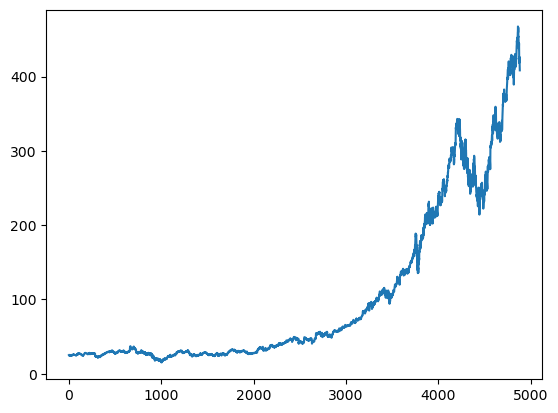

In [6]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [7]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
import numpy as np

In [8]:
df1

0        25.110001
1        24.910000
2        24.629999
3        24.540001
4        24.309999
           ...    
4876    426.730011
4877    422.920013
4878    418.350006
4879    417.109985
4880    408.489990
Name: Close, Length: 4881, dtype: float64

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
print(df1)

[[0.02201543]
 [0.02157335]
 [0.02095444]
 ...
 [0.891227  ]
 [0.88848608]
 [0.86943258]]


In [11]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [12]:
training_size,test_size

(3172, 1709)

In [13]:
train_data

array([[0.02201543],
       [0.02157335],
       [0.02095444],
       ...,
       [0.13697753],
       [0.13779536],
       [0.13814903]])

In [14]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [15]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [16]:
print(X_train.shape), print(y_train.shape)

(3071, 100)
(3071,)


(None, None)

In [17]:
print(X_test.shape), print(ytest.shape)

(1608, 100)
(1608,)


(None, None)

In [18]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [19]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [20]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
48/48 [==============================] - 50s 651ms/step - loss: 2.6010e-04 - val_loss: 0.0014
Epoch 2/100
48/48 [==============================] - 30s 625ms/step - loss: 1.0566e-05 - val_loss: 7.6607e-04
Epoch 3/100
48/48 [==============================] - 28s 582ms/step - loss: 1.0558e-05 - val_loss: 7.1743e-04
Epoch 4/100
48/48 [==============================] - 25s 512ms/step - loss: 9.8307e-06 - val_loss: 6.6359e-04
Epoch 5/100
48/48 [==============================] - 24s 499ms/step - loss: 9.7740e-06 - val_loss: 5.9297e-04
Epoch 6/100
48/48 [==============================] - 40s 841ms/step - loss: 1.0989e-05 - val_loss: 5.7695e-04
Epoch 7/100
48/48 [==============================] - 23s 485ms/step - loss: 9.1756e-06 - val_loss: 7.4859e-04
Epoch 8/100
48/48 [==============================] - 22s 463ms/step - loss: 9.0957e-06 - val_loss: 5.2790e-04
Epoch 9/100
48/48 [==============================] - 22s 461ms/step - loss: 8.4501e-06 - val_loss: 8.8136e-04
Epoch 10/100
4

48/48 [==============================] - 14s 299ms/step - loss: 3.2544e-06 - val_loss: 1.8331e-04
Epoch 76/100
48/48 [==============================] - 16s 328ms/step - loss: 3.4439e-06 - val_loss: 1.4747e-04
Epoch 77/100
48/48 [==============================] - 17s 359ms/step - loss: 3.2092e-06 - val_loss: 1.4671e-04
Epoch 78/100
48/48 [==============================] - 17s 347ms/step - loss: 2.7053e-06 - val_loss: 1.4738e-04
Epoch 79/100
48/48 [==============================] - 17s 353ms/step - loss: 3.1403e-06 - val_loss: 1.6634e-04
Epoch 80/100
48/48 [==============================] - 16s 344ms/step - loss: 2.9321e-06 - val_loss: 1.9166e-04
Epoch 81/100
48/48 [==============================] - 14s 282ms/step - loss: 2.7626e-06 - val_loss: 1.3619e-04
Epoch 82/100
48/48 [==============================] - 14s 300ms/step - loss: 3.1733e-06 - val_loss: 1.5939e-04
Epoch 83/100
48/48 [==============================] - 55s 1s/step - loss: 2.6083e-06 - val_loss: 1.3091e-04
Epoch 84/100
48/4

In [23]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [24]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

51/51 [==============================] - 3s 54ms/step


In [25]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [26]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

37.479677679183396

In [27]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

257.2750008542306

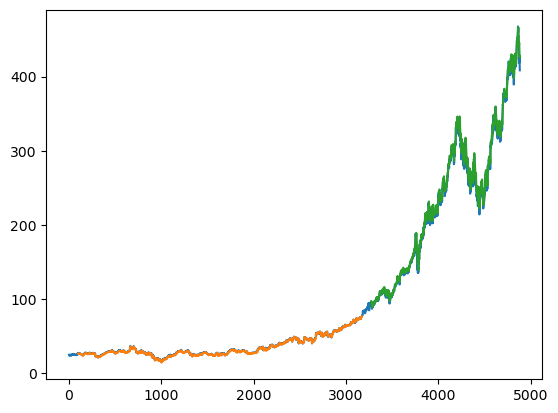

In [28]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [29]:
len(test_data)

1709

In [30]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 1368)

In [31]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [32]:
temp_input

[0.2144514896419243,
 0.21414203803692242,
 0.21524723023473055,
 0.21465043307906734,
 0.21341260676560023,
 0.21352313261653424,
 0.21051700762811168,
 0.2107822603867388,
 0.2159103521845686,
 0.21765655806748987,
 0.21960168970447905,
 0.21980061545854693,
 0.22271834054383563,
 0.22638756979902105,
 0.22656440497143918,
 0.2262770439480871,
 0.23224509065778867,
 0.2252381765444538,
 0.2265865132361641,
 0.22713910933506823,
 0.22461925565137483,
 0.22497292378582665,
 0.2272054164461679,
 0.2295926205415115,
 0.2299683969406883,
 0.23169249455888455,
 0.23034416007755862,
 0.23151565938646648,
 0.23160407697267557,
 0.23016732490514055,
 0.23217878133630457,
 0.23248823515169084,
 0.23385866242505096,
 0.234079714126919,
 0.23346079323384003,
 0.23567117762945636,
 0.2392078059247488,
 0.24006985362865477,
 0.24378329941329016,
 0.2428328341231751,
 0.2519838078379514,
 0.2536195033426294,
 0.2533542682670775,
 0.25518889173620785,
 0.2491766262866719,
 0.24548528876676148,
 0.25

In [33]:
import numpy as np

# Assuming temp_input and model are already defined
lst_output = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])  # Use the last n_steps elements
        print(f"{i} day input {x_input}")
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        print(f"{i} day output {yhat}")
        
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

print(lst_output)


0 day input [0.88444111 0.88404325 0.90641233 0.88696098 0.88895031 0.89799077
 0.90643446 0.91558541 0.91419286 0.90119579 0.89852124 0.89803496
 0.8964656  0.90497559 0.89805708 0.89586882 0.89018812 0.90707542
 0.90501978 0.90875533 0.90208    0.91240246 0.89907384 0.88081611
 0.88289381 0.87683738 0.86010475 0.84872129 0.85278838 0.86739906
 0.87069251 0.84854449 0.86463608 0.8556398  0.8270816  0.83948189
 0.845892   0.8653876  0.88059506 0.87131142 0.87396391 0.87789839
 0.88324748 0.88099291 0.8872704  0.90168208 0.89706238 0.89533828
 0.90667757 0.91485602 0.91812734 0.91034681 0.91733164 0.91768531
 0.91514338 0.8830928  0.88410956 0.88055081 0.88618733 0.90373779
 0.90486504 0.90338412 0.91226984 0.92290178 0.94142481 0.94257419
 0.94476251 0.95758272 0.95309564 0.95168103 0.96069937 0.95603549
 0.96328555 0.96596009 0.96748526 0.95444401 0.97606157 0.98169802
 0.98499147 1.         0.99708227 0.98227274 0.9971044  0.97157449
 0.96903249 0.96993876 0.96012465 0.94686234 0.939

8 day output [[0.9202278]]
9 day input [0.90119579 0.89852124 0.89803496 0.8964656  0.90497559 0.89805708
 0.89586882 0.89018812 0.90707542 0.90501978 0.90875533 0.90208
 0.91240246 0.89907384 0.88081611 0.88289381 0.87683738 0.86010475
 0.84872129 0.85278838 0.86739906 0.87069251 0.84854449 0.86463608
 0.8556398  0.8270816  0.83948189 0.845892   0.8653876  0.88059506
 0.87131142 0.87396391 0.87789839 0.88324748 0.88099291 0.8872704
 0.90168208 0.89706238 0.89533828 0.90667757 0.91485602 0.91812734
 0.91034681 0.91733164 0.91768531 0.91514338 0.8830928  0.88410956
 0.88055081 0.88618733 0.90373779 0.90486504 0.90338412 0.91226984
 0.92290178 0.94142481 0.94257419 0.94476251 0.95758272 0.95309564
 0.95168103 0.96069937 0.95603549 0.96328555 0.96596009 0.96748526
 0.95444401 0.97606157 0.98169802 0.98499147 1.         0.99708227
 0.98227274 0.9971044  0.97157449 0.96903249 0.96993876 0.96012465
 0.94686234 0.93989964 0.93269377 0.94558035 0.94980219 0.91454653
 0.89133749 0.90652282 0.90

17 day output [[0.93865705]]
18 day input [0.90501978 0.90875533 0.90208    0.91240246 0.89907384 0.88081611
 0.88289381 0.87683738 0.86010475 0.84872129 0.85278838 0.86739906
 0.87069251 0.84854449 0.86463608 0.8556398  0.8270816  0.83948189
 0.845892   0.8653876  0.88059506 0.87131142 0.87396391 0.87789839
 0.88324748 0.88099291 0.8872704  0.90168208 0.89706238 0.89533828
 0.90667757 0.91485602 0.91812734 0.91034681 0.91733164 0.91768531
 0.91514338 0.8830928  0.88410956 0.88055081 0.88618733 0.90373779
 0.90486504 0.90338412 0.91226984 0.92290178 0.94142481 0.94257419
 0.94476251 0.95758272 0.95309564 0.95168103 0.96069937 0.95603549
 0.96328555 0.96596009 0.96748526 0.95444401 0.97606157 0.98169802
 0.98499147 1.         0.99708227 0.98227274 0.9971044  0.97157449
 0.96903249 0.96993876 0.96012465 0.94686234 0.93989964 0.93269377
 0.94558035 0.94980219 0.91454653 0.89133749 0.90652282 0.90975003
 0.90132847 0.891227   0.88848608 0.86943258 0.8903836  0.8911218
 0.89604294 0.9015920

25 day output [[0.9560557]]
26 day input [0.86010475 0.84872129 0.85278838 0.86739906 0.87069251 0.84854449
 0.86463608 0.8556398  0.8270816  0.83948189 0.845892   0.8653876
 0.88059506 0.87131142 0.87396391 0.87789839 0.88324748 0.88099291
 0.8872704  0.90168208 0.89706238 0.89533828 0.90667757 0.91485602
 0.91812734 0.91034681 0.91733164 0.91768531 0.91514338 0.8830928
 0.88410956 0.88055081 0.88618733 0.90373779 0.90486504 0.90338412
 0.91226984 0.92290178 0.94142481 0.94257419 0.94476251 0.95758272
 0.95309564 0.95168103 0.96069937 0.95603549 0.96328555 0.96596009
 0.96748526 0.95444401 0.97606157 0.98169802 0.98499147 1.
 0.99708227 0.98227274 0.9971044  0.97157449 0.96903249 0.96993876
 0.96012465 0.94686234 0.93989964 0.93269377 0.94558035 0.94980219
 0.91454653 0.89133749 0.90652282 0.90975003 0.90132847 0.891227
 0.88848608 0.86943258 0.8903836  0.8911218  0.89604294 0.90159202
 0.90674728 0.91120148 0.91487968 0.91784036 0.92022783 0.92222548
 0.92401868 0.92576551 0.9275803 

In [34]:
import matplotlib.pyplot as plt
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [35]:
len(df1)

4881

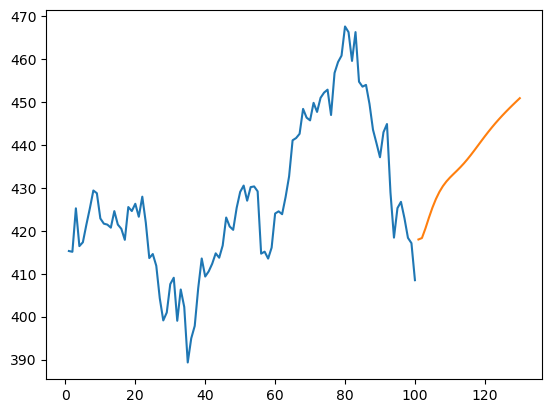

In [36]:
plt.plot(day_new,scaler.inverse_transform(df1[4781:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

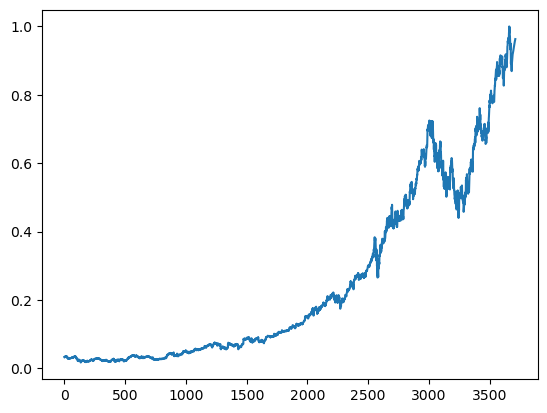

In [37]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [38]:
df3=scaler.inverse_transform(df3).tolist()

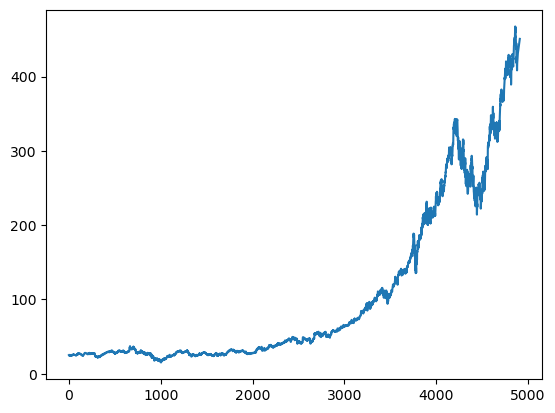

In [39]:
plt.plot(df3)